In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../external_dependencies/pyceres/")

In [3]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import pycolmap
import pyceres

from tqdm import tqdm

from megadepth.utils.projections import get_camera_poses
from megadepth.visualization.view_projections import align_models

# Plotting models

In [4]:
def get_poses(reconstruction):
    cameras = reconstruction.cameras
    images = reconstruction.images

    poses = {}
    for im in images.values():
        camera = cameras[im.camera_id]
        p_world = np.array(camera.image_to_world([[0, 0]]))
        p_world = np.stack([p_world[:, 0], p_world[:, 1], np.ones_like(p_world[:, 0])])
        p_world = np.array(im.transform_to_world(p_world.T))

        poses[im.name] = p_world[0]

    return poses

def plot_model(reconstruction, tilt=-45):
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection="3d"))

    p3d = np.array([p.xyz for p in reconstruction.points3D.values() if p.track.length() > 2 and p.error < 8])
    cam_tvecs = get_camera_poses(reconstruction)

    p_colors = [(0, 0, 0) for _ in p3d]
    ax.scatter(p3d[:, 0], p3d[:, 1], p3d[:, 2], s=0.1, marker=".", alpha=0.05, c=p_colors)
    
    cam_colors = [(1, 0, 0) for _ in cam_tvecs]
    ax.scatter(cam_tvecs[:, 0], cam_tvecs[:, 1], cam_tvecs[:, 2], s=10, marker=".", alpha=0.5, c=cam_colors)

    # bbox = (-5, 5)

    # ax.set_xlim(*bbox)
    # ax.set_ylim(*bbox)
    # ax.set_zlim(*bbox)

    ax.set_xlim(cam_tvecs[:, 0].min(), cam_tvecs[:, 0].max())
    ax.set_ylim(cam_tvecs[:, 1].min(), cam_tvecs[:, 1].max())
    ax.set_zlim(cam_tvecs[:, 2].min(), cam_tvecs[:, 2].max())

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    # flip x and z 
    ax.view_init(tilt, -90, 0)

    plt.show()

def plot_uncs(reconstruction, uncs, cam_tvecs, tilt=-45):
    cmap = dict(cmap='turbo', norm=plt.Normalize(0, uncs.max() * 100))
    # cmap = dict(cmap='turbo', norm=plt.Normalize(0, 0.2))
    


    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection="3d"))

    p3d = np.array([p.xyz for p in reconstruction.points3D.values() if p.track.length() > 2 and p.error < 8])

    p_colors = [(0, 0, 0) for _ in p3d]
    ax.scatter(p3d[:, 0], p3d[:, 1], p3d[:, 2], s=0.1, marker=".", alpha=0.05, c=p_colors)

    obj = ax.scatter(cam_tvecs[:, 0], cam_tvecs[:, 1], cam_tvecs[:, 2], s=100, marker=".", alpha=0.5, c=uncs * 100, **cmap)

    ax.get_figure().colorbar(obj, ax=ax)

    # bbox = (-5, 5)

    # ax.set_xlim(*bbox)
    # ax.set_ylim(*bbox)
    # ax.set_zlim(*bbox)

    ax.set_xlim(cam_tvecs[:, 0].min(), cam_tvecs[:, 0].max())
    ax.set_ylim(cam_tvecs[:, 1].min(), cam_tvecs[:, 1].max())
    ax.set_zlim(cam_tvecs[:, 2].min(), cam_tvecs[:, 2].max())

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    # flip x and z 
    ax.view_init(tilt, -90, 0)

    plt.show()

# Pyceres Magic

In [5]:
def solve(prob):
    print(prob.num_parameter_blocks(), prob.num_parameters(), prob.num_residual_blocks(), prob.num_residuals())
    options = pyceres.SolverOptions()
    # CGNR, DENSE_NORMAL_CHOLESKY, DENSE_QR, DENSE_SCHUR, ITERATIVE_SCHUR, SPARSE_NORMAL_CHOLESKY, SPARSE_SCHUR
    options.linear_solver_type = pyceres.LinearSolverType.SPARSE_NORMAL_CHOLESKY
    options.minimizer_progress_to_stdout = True
    options.max_num_iterations = 0
    options.num_threads = -1
    summary = pyceres.SolverSummary()
    pyceres.solve(options, prob, summary)
    print(summary.BriefReport())

def opt_poses(rec):
    prob = pyceres.Problem()
    loss = pyceres.TrivialLoss()
    for im in tqdm(rec.images.values()):
        cam = rec.cameras[im.camera_id]
        for p in im.points2D:
            cost = pyceres.factors.BundleAdjustmentCost(cam.model_id, p.xy)
            if p.has_point3D():
                prob.add_residual_block(cost, loss, [im.qvec, im.tvec, rec.points3D[p.point3D_id].xyz, cam.params])
        prob.set_manifold(im.qvec, pyceres.QuaternionManifold())
    for cam in rec.cameras.values():
        prob.set_parameter_block_constant(cam.params)
    for p in rec.points3D.values():
        prob.set_parameter_block_constant(p.xyz)
    return prob

def compute_pose_covariances(problem: pyceres.Problem, qts):
    opts = pyceres.CovarianceOptions(
        dict(
            num_threads=-1, 
            algorithm_type=pyceres.CovarianceAlgorithmType.SPARSE_QR,
        )
    )
    cov = pyceres.Covariance(opts)
    blocks = []
    for q, t in qts.values():
        blocks.extend([(t, t), (q, q), (q, t)])
    assert cov.compute(blocks, problem), "Failed to compute covariance"
    covariances = {}
    for k, (q, t) in qts.items():
        c_qq = cov.get_covariance_block_tangent_space(q, q, problem)
        c_tt = cov.get_covariance_block(t, t)
        c_qt = cov.get_covariance_block_tangent_space(q, t, problem)
        covariances[k] = np.block([[c_qq, c_qt], [c_qt.T, c_tt]])
    return covariances

In [6]:
def run(reconstruction):
    plot_model(reconstruction, 0)

    # run ba
    problem = opt_poses(reconstruction)
    solve(problem)

    # get covars
    qts = {im.name: (im.qvec, im.tvec) for im in reconstruction.images.values()}
    qts_cov = compute_pose_covariances(problem, qts)

    # get uncertainties
    keys = qts.keys()

    poses = get_poses(reconstruction)
    cam_tvecs = np.array([poses[k] for k in keys])
    covars = np.stack([qts_cov[k][3:, 3:] for k in keys])
    uncs = np.sqrt(np.linalg.eig(covars)[0].max(1))

    # plot uncertainties histogram
    print(f"Min, Median, Mean, Max: {uncs.min()*100:.2f}, {np.median(uncs)*100:.2f}, {uncs.mean()*100:.2f}, {uncs.max()*100:.2f}")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.hist(uncs*100, bins=100)
    ax.set_title('Uncertainty Histogram')
    plt.show()

    # plot
    plot_uncs(reconstruction, uncs, cam_tvecs, 0)

In [23]:
data = Path("/Volumes/Extreme_SSD/MegaDepth/scenes")
# data = Path("../../data/scenes/")

scene = "0229"

# model_name = "disk_lg+sift+splg"
model_name = "disk+sift+spsg"
# model_name = "geo-model"

model_path = data / scene / "sparse" / model_name

reconstruction = pycolmap.Reconstruction(model_path)

# reconstruction.normalize(0.5, 0, 1, True)

model_name = "baseline"
model_path = data / scene / "sparse" / model_name
baseline = pycolmap.Reconstruction(model_path)
baseline = align_models(reconstruction, baseline)

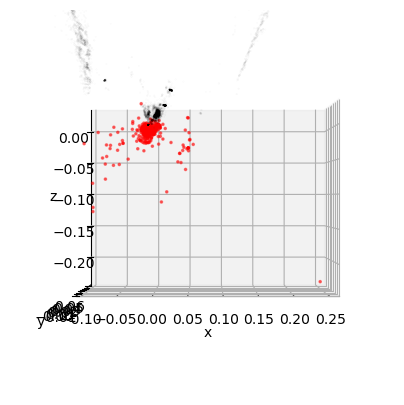

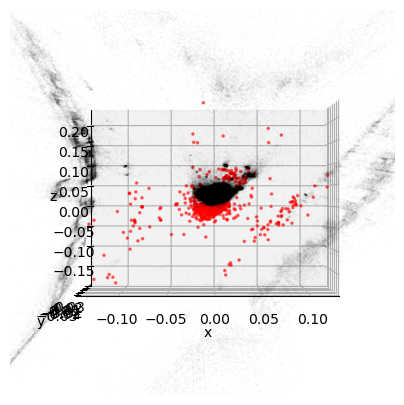

In [24]:
plot_model(baseline, 0)
plot_model(reconstruction, 0)

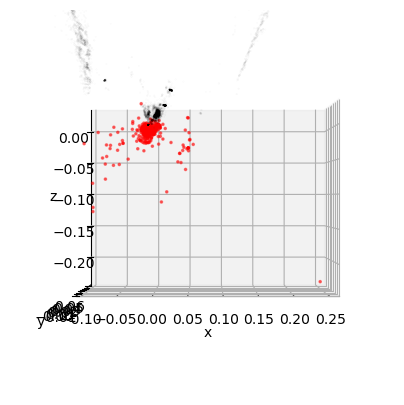

100%|██████████| 318/318 [00:07<00:00, 45.26it/s]


12955 39501 93921 187842
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.705451e+04    0.00e+00    3.34e+07   0.00e+00   0.00e+00  1.00e+04        0    1.23e-02    4.16e-02
Ceres Solver Report: Iterations: 1, Initial cost: 2.705451e+04, Final cost: 2.705451e+04, Termination: NO_CONVERGENCE
Min, Median, Mean, Max: 0.00, 0.00, 0.01, 0.28


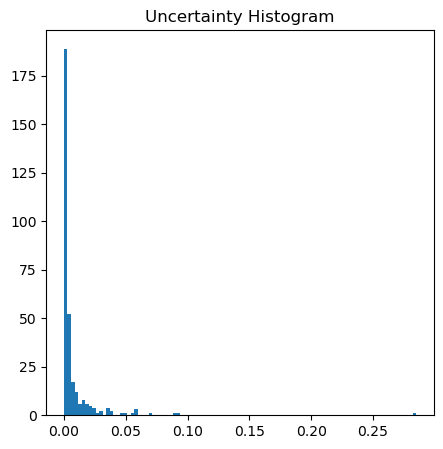

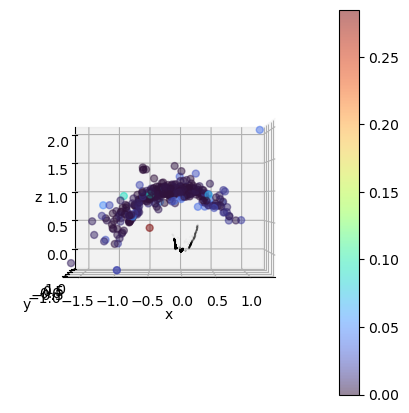

In [25]:
run(baseline)

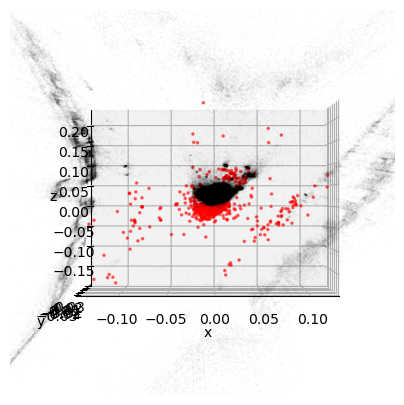

100%|██████████| 681/681 [01:01<00:00, 11.08it/s]


290587 873055 2502790 5005580
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  9.052478e+17    0.00e+00    7.28e+20   0.00e+00   0.00e+00  1.00e+04        0    3.33e-01    1.41e+00
Ceres Solver Report: Iterations: 1, Initial cost: 9.052478e+17, Final cost: 9.052478e+17, Termination: NO_CONVERGENCE


W20230821 17:42:31.752869 3868729472 covariance_impl.cc:647] Jacobian matrix is rank deficient. Number of columns: 4086 rank: 3918


AssertionError: Failed to compute covariance

In [26]:
run(reconstruction)